In [1]:
#from qiime_default_reference import get_reference_sequences
import random

from skbio import DNA
import skbio.io
import pandas as pd
import numpy as np

#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

from sklearn import cluster
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from scipy.cluster.hierarchy import linkage, dendrogram

from skbio.alignment import local_pairwise_align_ssw

import os 

import matplotlib.pyplot as plt

from sklearn.manifold import MDS
from scipy.cluster.hierarchy import cut_tree

import seaborn as sns

## Load the dataset and data preprocessing

In [20]:
sequences = []
fraction_to_keep = 0.01

# RDP trainset 16
# https://www.mothur.org/wiki/RDP_reference_files
# http://rdp.cme.msu.edu/classifier/hierarchy.jsp
for e in skbio.io.read('trainset16.fasta', format = 'fasta'):
    if random.random() < fraction_to_keep:
        sequences.append(e)
        
print(len(sequences))  

140


In [21]:
# Take a look at our data
sequences[0]

Sequence
-----------------------------------------------------------------------
Metadata:
    'description': 'Root;Bacteria;"Proteobacteria";Alphaproteobacteria;
                    Rhodospirillales;Acetobacteraceae;Roseomonas'
    'id': 'FM244739|S001265329'
Stats:
    length: 1390
-----------------------------------------------------------------------
0    acacatgcaa gtcgcacggg cagcaatgtc agtggcggac gggtgagtaa cgcgtaggga
60   agtgtccaga ggtgggggac aaccccggga actggggcta ataccgcata tggcctgagg
...
1320 tctaccttaa gcaggtgcgc gaacccgcaa gggatgtagc ttgccacggt agggtcagcg
1380 actggggtga

Data Transformation

In [22]:
labels = {}
classes = []
seq_idx = 0
for sequence in sequences:
    descriptions = sequence.metadata['description'].split(';')
    #seq_id = sequence.metadata['id']
    label = descriptions[2]
    if label[0] == '"':
        label = label[1:]
    if label[-1] == '"':
        label = label[:-1]
    
    classes.append(label)
    if label in labels:
        labels[label].append(seq_idx)
    else:
        labels[label] = [seq_idx]
    seq_idx += 1

In [23]:
print(set(classes))
print("There are %d categories" %len(set(classes)))

{'Spirochaetes', 'Tenericutes', 'Proteobacteria', 'Cyanobacteria/Chloroplast', 'Bacteroidetes', 'Synergistetes', 'Euryarchaeota', 'Actinobacteria', 'Acidobacteria', 'Chloroflexi', 'BRC1', 'Marinimicrobia', 'Firmicutes', 'Armatimonadetes'}
There are 14 categories


Take a look at the number of sequences in each category

In [24]:
for k, v in labels.items():
    print(k, len(v))

Proteobacteria 50
Firmicutes 16
Actinobacteria 29
Cyanobacteria/Chloroplast 2
Tenericutes 3
Bacteroidetes 21
Chloroflexi 1
Euryarchaeota 8
Marinimicrobia 1
Acidobacteria 2
Synergistetes 2
Spirochaetes 1
BRC1 1
Armatimonadetes 3


Take a look at sequences in 'Firmicutes' category

In [25]:
print(labels['Firmicutes'])

[2, 12, 16, 17, 46, 49, 77, 79, 82, 86, 89, 93, 114, 132, 134, 135]


Take a look at first ten sequence true class labels

In [26]:
print(classes[: 10])

['Proteobacteria', 'Proteobacteria', 'Firmicutes', 'Proteobacteria', 'Proteobacteria', 'Actinobacteria', 'Cyanobacteria/Chloroplast', 'Actinobacteria', 'Proteobacteria', 'Tenericutes']


## Sequence alignment - local ssw

In [27]:
def compute_distance_matrix(sequences):
    num_seqs = len(sequences)
    
    score_matrix = pd.DataFrame(np.zeros((num_seqs, num_seqs)))
    distance_matrix = pd.DataFrame(np.zeros((num_seqs, num_seqs)))
    
    for i in range(num_seqs):
        for j in range(i, num_seqs):
                s_i = DNA(sequences[i], lowercase = True)
                s_j = DNA(sequences[j], lowercase = True)
                alignment, score, start_end_positions = local_pairwise_align_ssw(s_i, s_j)
                score_matrix[i][j] = score
                distance_matrix[i][j]= alignment[0].distance(alignment[1])
    
    for i in range(num_seqs):
        for j in range(i):
            score_matrix[i][j] = score_matrix[j][i]
            distance_matrix[i][j] = distance_matrix[j][i]
            
    return score_matrix, distance_matrix

In [28]:
score_matrix, distance_matrix = compute_distance_matrix(sequences)

## Multidimensional scaling

convert the dist matrix into a 2-dimensional array

In [29]:
def convert_distance_matrix_for_vis(distance_matrix):
    MDS()
    
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
    pos = mds.fit_transform(distance_matrix)  
    
    #xs, ys = pos[:, 0], pos[:, 1]
    #return xs, ys
    return pos

In [30]:
pos = convert_distance_matrix_for_vis(distance_matrix)

## Visualization of True-labeled sequence distribution

In [114]:
cluster_colors = {0: '#1b9e77', 
                  1: '#d95f02', 
                  2: '#7570b3', 
                  3: '#e7298a', 
                  4: '#66a61e',
                  5: '#ca9785',
                  6: '#118c8b',
                  7: '#ffe400',
                  8: '#5c4a72',
                  9: '#ffb6c1',
                  10:'#a0db8e',
                  11:'#323339',
                  12:'#5d5c61',
                  13:'#e27d60'}

#set up cluster names using a dict
cluster_names = {'Acidobacteria': 0,
                  'Actinobacteria':1,
                  'Bacteroidetes':2,
                  'BRC1':3,
                  'Chloroflexi':4,
                  'Armatimonadetes':5,
                  'Euryarchaeota':6,
                  'Proteobacteria':7,
                  'Tenericutes':8,
                  'Spirochaetes':9,
                  'Synergistetes':10,
                  'Marinimicrobia':11,
                  'Cyanobacteria/Chloroplast':12,
                  'Firmicutes':13}

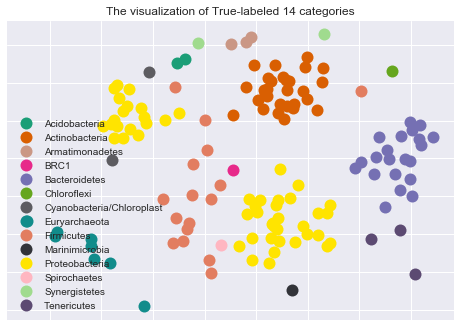

In [108]:
df = pd.DataFrame(dict(x=pos[:,0], y=pos[:,1], label=classes)) 
    #group by cluster
groups = df.groupby('label')
n_clusters = len(set(classes))    
fig, ax = plt.subplots()
    
for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', 
                label=name, color= cluster_colors[cluster_names[name]],
                ms=12, mec='none')
        ax.set_aspect('auto')
        ax.tick_params(axis= 'x',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        bottom='off',      # ticks along the bottom edge are off
                        top='off',         # ticks along the top edge are off
                        labelbottom='off')
        ax.tick_params(axis= 'y',         # changes apply to the y-axis
                        which='both',      # both major and minor ticks are affected
                        left='off',      # ticks along the bottom edge are off
                        top='off',         # ticks along the top edge are off
                        labelleft='off')

ax.margins(0.05)    
ax.legend(numpoints=1)  #show legend with only 1 point
ax.set_title("The visualization of True-labeled %d categories" %n_clusters)

# K-means

In [44]:
def kmeans_cluster(sequences, num_clusters, 
                   score_matrix = score_matrix, 
                   distance_matrix = distance_matrix):
    num_seqs = len(sequences)
#     score_matrix, distance_matrix = compute_distance_matrix(sequences)
    
    kmeans = KMeans(num_clusters)
    results = kmeans.fit(score_matrix)
    
    labels = results.labels_
    centroids = kmeans.cluster_centers_
    #clusters = [[] for i in range(num_clusters)]
    clusters = {}
    for i in range(0, num_seqs):
        #clusters[labels[i]].append(sequences[i].metadata['id'])
        cluster_id = labels[i]
        if cluster_id in clusters:
            clusters[cluster_id].append(i)
        else:
            clusters[cluster_id]= [i]
        
    return labels, clusters

In [ ]:
# Compute knn clustering results
# %time score_matrix, distance_matrix, clusters, centroids, labels = knn_cluster(sequences, 5)

## Visualizing document clusters

In [48]:
# Visualization of kmeans
def visualize_kmeans(pos, score_matrix, labels):

    df = pd.DataFrame(dict(x=pos[:,0], y=pos[:,1], label=labels.tolist())) 

    #group by cluster
    groups = df.groupby('label')
    n_clusters = len(groups)
    num_seqs = len(df)

    # set up plot
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, num_seqs + (n_clusters + 1) * 10])

    silhouette_avg = silhouette_score(score_matrix, labels)
    sample_silhouette_values = silhouette_samples(score_matrix, labels)
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_clusters, silhouette_avg))
    
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10 

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    for name, group in groups:
        ax2.plot(group.x, group.y, marker='o', 
                 linestyle='', label=str(name), 
                 color=cluster_colors[name],
                 ms=12, mec='none')
        ax2.set_aspect('auto')
        ax2.tick_params(axis= 'x',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        bottom='off',      # ticks along the bottom edge are off
                        top='off',         # ticks along the top edge are off
                        labelbottom='off')
        ax2.tick_params(axis= 'y',         # changes apply to the y-axis
                        which='both',      # both major and minor ticks are affected
                        left='off',      # ticks along the bottom edge are off
                        top='off',         # ticks along the top edge are off
                        labelleft='off')

    ax2.margins(0.05)    
    ax2.legend(numpoints=1)  #show legend with only 1 point
    ax2.set_title("The visualization of the clustered data.")


    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
   
    plt.plot()


## K-means visualization

For n_clusters=3, The Silhouette Coefficient is 0.4007769691786452
For n_clusters=5, The Silhouette Coefficient is 0.41120944025499645
For n_clusters=7, The Silhouette Coefficient is 0.455802510941555
For n_clusters=9, The Silhouette Coefficient is 0.4083965582424128
For n_clusters=11, The Silhouette Coefficient is 0.35557203864308057
For n_clusters=13, The Silhouette Coefficient is 0.33912314896850826
For n_clusters=15, The Silhouette Coefficient is 0.3621948752381777
For n_clusters=17, The Silhouette Coefficient is 0.28064625654883446
For n_clusters=19, The Silhouette Coefficient is 0.29686224447482434


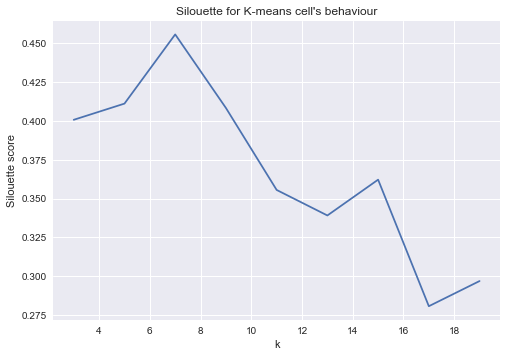

In [46]:
Nc = range(3, 20, 2)
s = []
for i in Nc:
    labels, clusters = kmeans_cluster(sequences, i)
    score = silhouette_score(score_matrix, labels)
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(i, score))
    s.append(score)
    
plt.plot(Nc,s)
plt.grid(True)
plt.ylabel("Silouette score")
plt.xlabel("k")
plt.title("Silouette for K-means cell's behaviour")

For n_clusters=3, The Silhouette Coefficient is 0.4007769691786452
For n_clusters=7, The Silhouette Coefficient is 0.4545276832092076
For n_clusters=11, The Silhouette Coefficient is 0.34794317302711203
For n_clusters=13, The Silhouette Coefficient is 0.33532562463050153


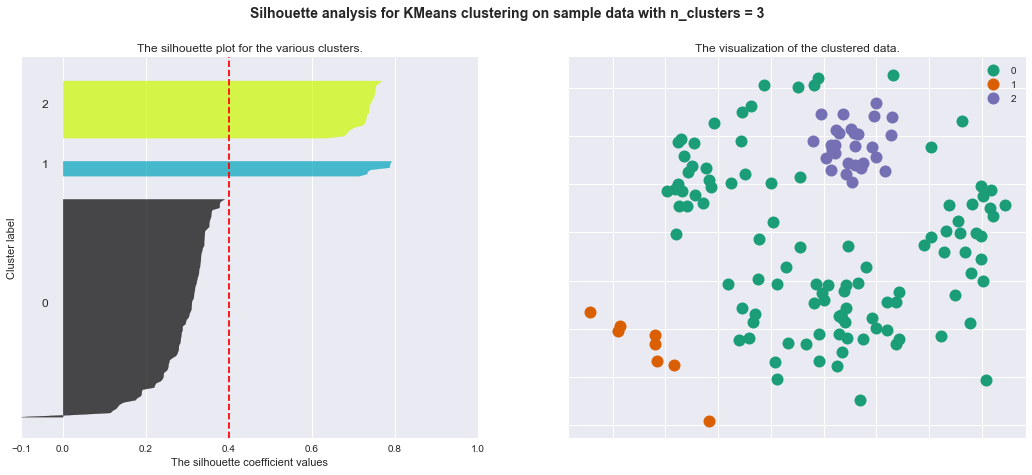

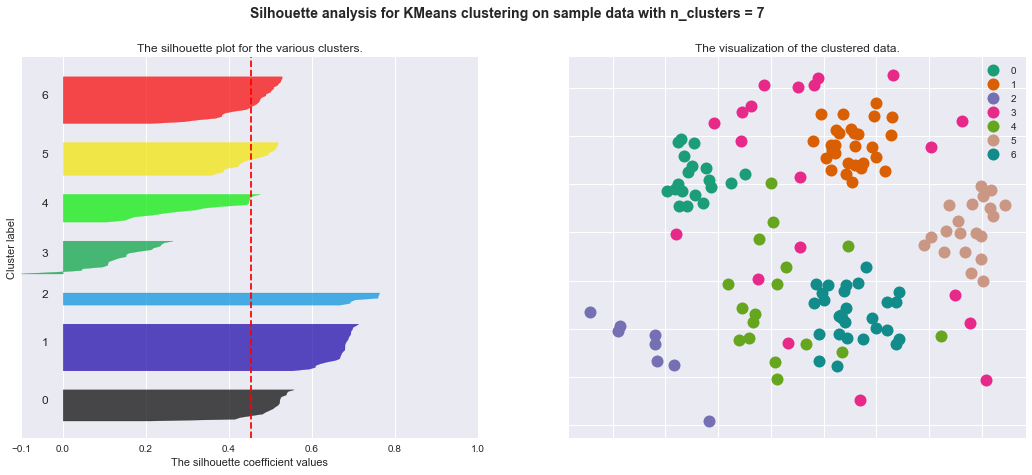

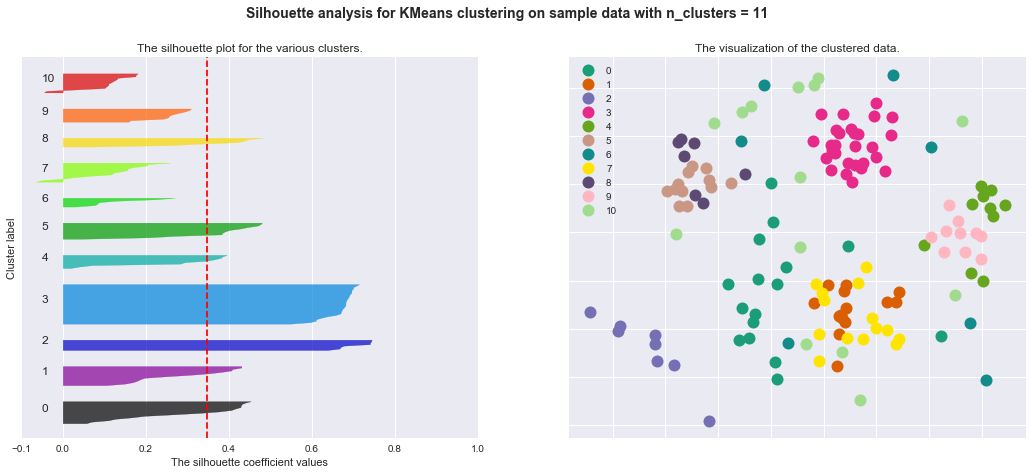

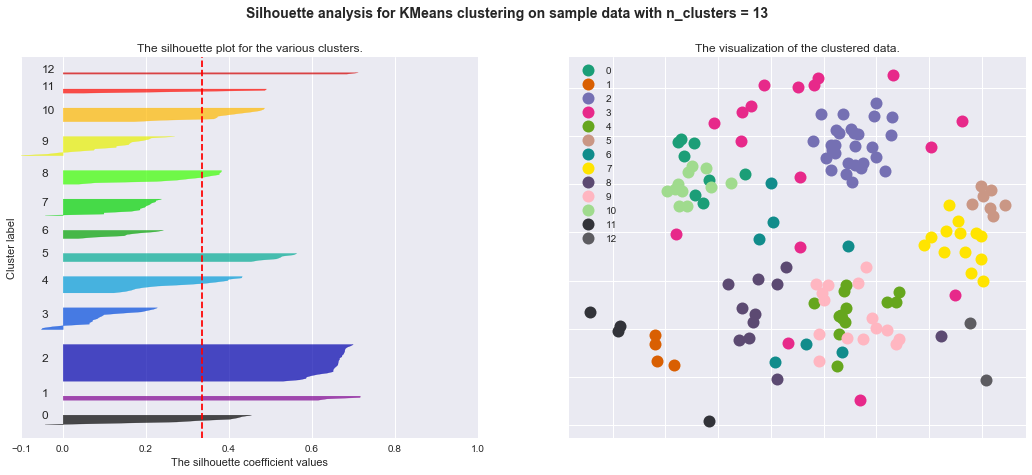

In [112]:
# Take a look at two clustering example with n = 3 and n = 5

ns = [3,7,11,13]
for i in ns:
    labels, clusters = kmeans_cluster(sequences, i)
    visualize_kmeans(pos, score_matrix, labels)

# Hierarchical clustering

In [50]:
def visualize_dendrogram(linkage_name, linkage_matrix, p = 12):
    
    # Full dendrogram
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    no_spine = {'left': True, 'bottom': True, 'right': True, 'top': True}

    ax1 = plt.subplot(1, 2, 1)
    ax1.title.set_text(linkage_name + ' linkage')
    dendrogram(linkage_matrix, leaf_rotation=90.)
    
    # Truncated dendrogram
    ax2 = plt.subplot(1,2,2)
    ax2.title.set_text(linkage_name +' linkage Hierarchical Clustering Dendrogram (truncated) by last %d merge' %p)
    ax2.set_ylabel("distance")
    ax2.set_xlabel("sample index or (cluster size)")
    dendrogram(linkage_matrix,
               truncate_mode='lastp',  # show only the last p merged clusters
               p=p,  # show only the last p merged clusters
               leaf_rotation=90.,
               leaf_font_size=12.,
               show_contracted=True,)  # to get a distribution impression in truncated branches

    sns.despine(**no_spine);
    plt.tight_layout() #show plot with tight layout
    plt.plot()
    

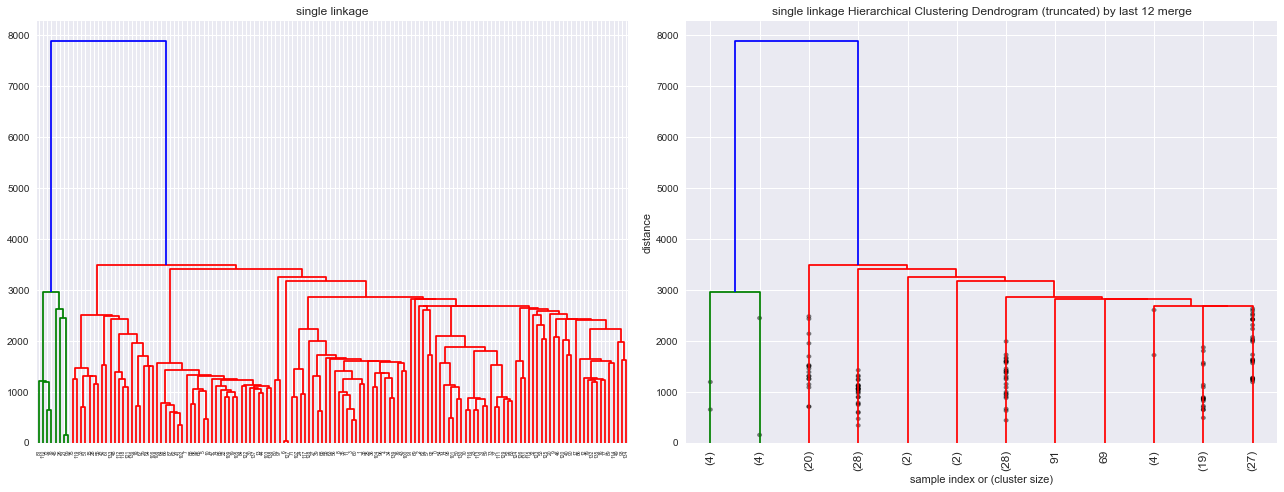

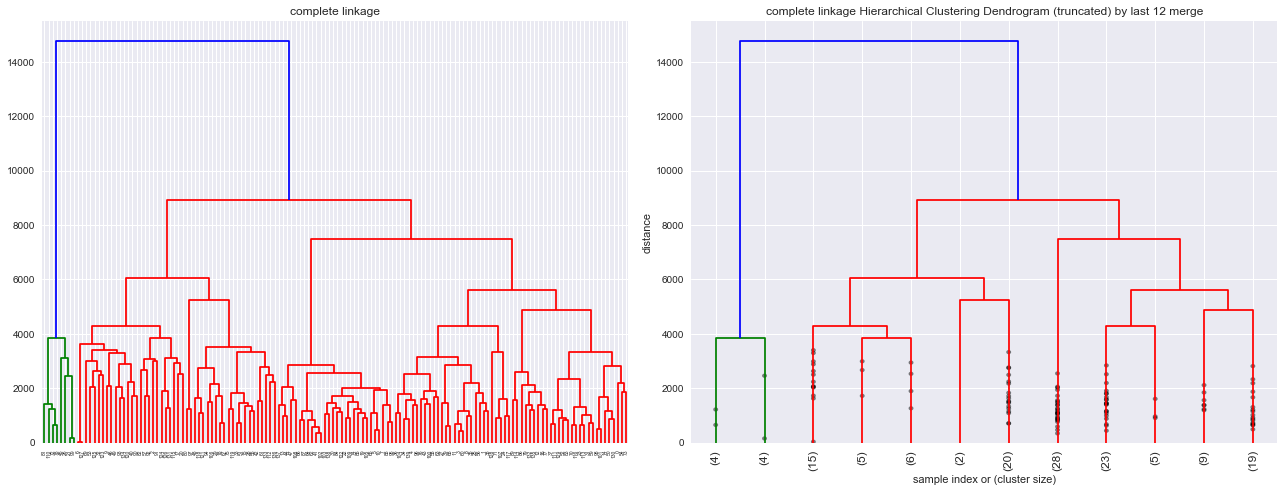

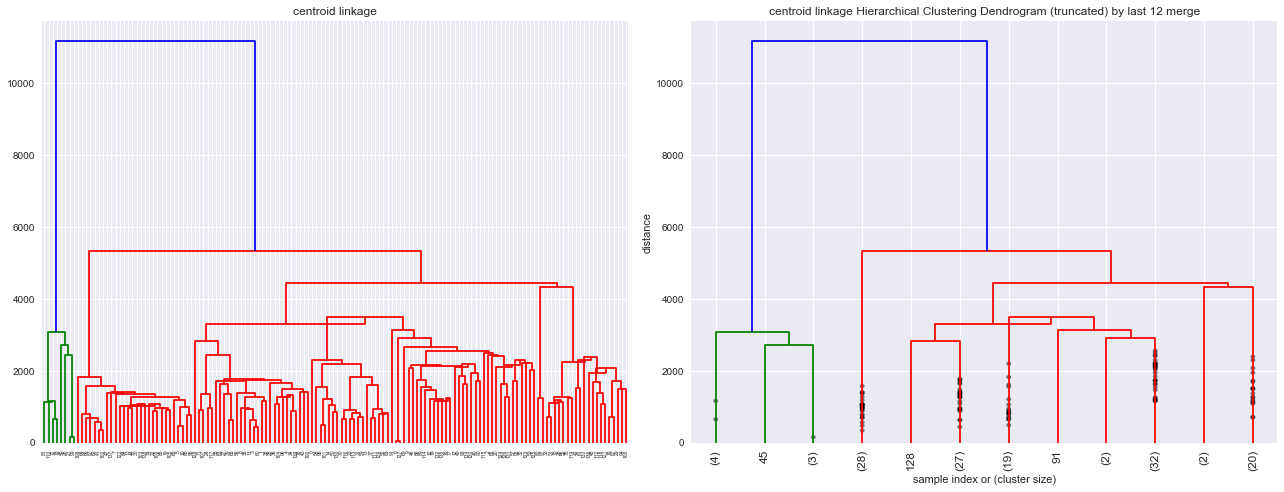

In [53]:
methods = ['single', 'complete', 'centroid']
# linkage_matrix = ward(distance_matrix) #define the linkage_matrix using ward clustering pre-computed distances
linkage_matrix = {}

for method in methods:
    linkage_matrix[method] = linkage(score_matrix, method=method)
    visualize_dendrogram(method, linkage_matrix[method])


In [ ]:
# Visualize cluster results of hierachy clustering

In [92]:
def visualize_hc(pos, score_matrix, linkage_name, linkage_matrix, n_clusters):
    
    cuts = cut_tree(linkage_matrix, n_clusters = n_clusters)
    size = len(cuts)
    labels = cuts.reshape((size,))
    
    score = silhouette_score(score_matrix, labels)
    print("For " + linkage_name + " linkage Hierarchical Clustering, the Silhouette Coefficient with {} is {}".format(n_clusters, score))
    
    df = pd.DataFrame(dict(x=pos[:,0], y=pos[:,1], label=labels.tolist())) 
    #group by cluster
    groups = df.groupby('label')
    
    fig, ax = plt.subplots()
    
    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', 
                label=str(name), color=cluster_colors[name],
                ms=12, mec='none')
        ax.set_aspect('auto')
        ax.tick_params(axis= 'x',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        bottom='off',      # ticks along the bottom edge are off
                        top='off',         # ticks along the top edge are off
                        labelbottom='off')
        ax.tick_params(axis= 'y',         # changes apply to the y-axis
                        which='both',      # both major and minor ticks are affected
                        left='off',      # ticks along the bottom edge are off
                        top='off',         # ticks along the top edge are off
                        labelleft='off')

    ax.margins(0.05)    
    ax.legend(numpoints=1)  #show legend with only 1 point
    ax.set_title("The visualization of " + linkage_name  + " linkage Hierarchical Clustering with n_clusters = %d" %n_clusters)
    
    plt.plot()
    

For single linkage Hierarchical Clustering, the Silhouette Coefficient with 7 is 0.29302476911079
For complete linkage Hierarchical Clustering, the Silhouette Coefficient with 7 is 0.41345886046628455
For centroid linkage Hierarchical Clustering, the Silhouette Coefficient with 7 is 0.04876989286122942


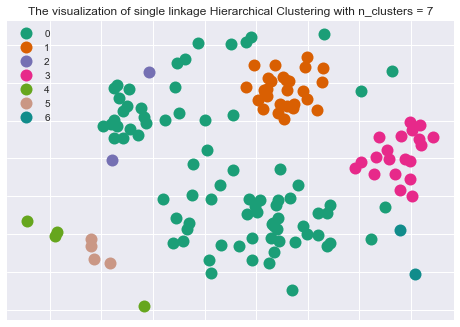

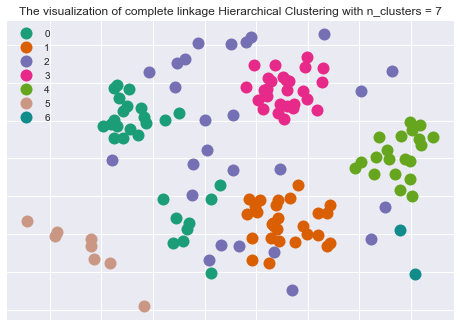

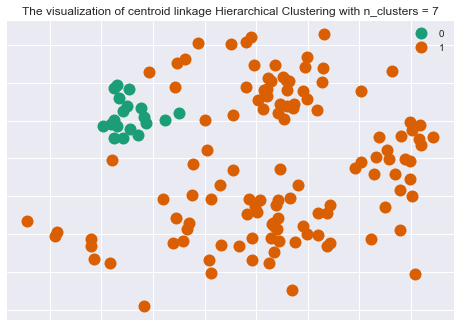

In [115]:
for method in methods:
    visualize_hc(pos, score_matrix, method, linkage_matrix[method], n_clusters = 7)
    #get_cluster_classes(den)

In [ ]:
# Try with different specified cluster = 11

For single linkage Hierarchical Clustering, the Silhouette Coefficient with 11 is 0.34459980103494176
For complete linkage Hierarchical Clustering, the Silhouette Coefficient with 11 is 0.40998990328296697
For centroid linkage Hierarchical Clustering, the Silhouette Coefficient with 11 is 0.018162890807090427


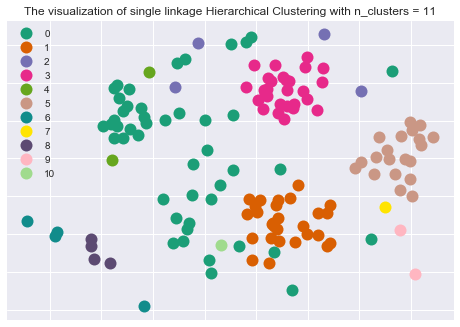

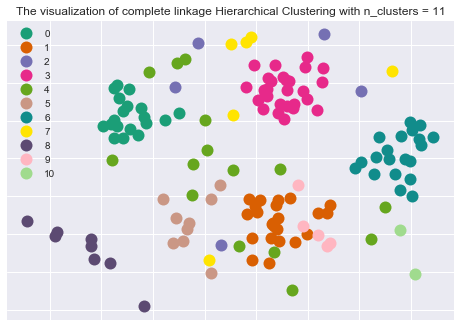

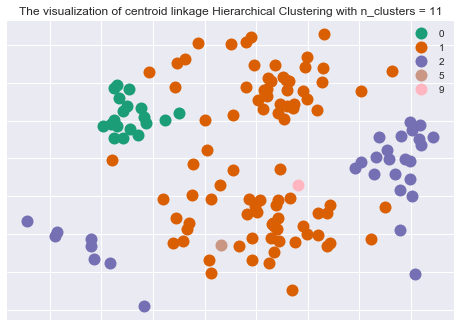

In [102]:
for method in methods:
    visualize_hc(pos, score_matrix, method, linkage_matrix[method], n_clusters = 11)

 Again the centroid clustering returns less than required number of clusters

## Silhouette analysis on single linkage clustering with different number of clusters

For Single linkage Hierarchical Clustering, the Silhouette Coefficient with 3 is 0.3106031777800746
For Single linkage Hierarchical Clustering, the Silhouette Coefficient with 5 is 0.39151288993884653
For Single linkage Hierarchical Clustering, the Silhouette Coefficient with 7 is 0.29302476911079
For Single linkage Hierarchical Clustering, the Silhouette Coefficient with 9 is 0.357524511268532
For Single linkage Hierarchical Clustering, the Silhouette Coefficient with 11 is 0.34459980103494176
For Single linkage Hierarchical Clustering, the Silhouette Coefficient with 13 is 0.4052606547291855
For Single linkage Hierarchical Clustering, the Silhouette Coefficient with 15 is 0.4051088000800335


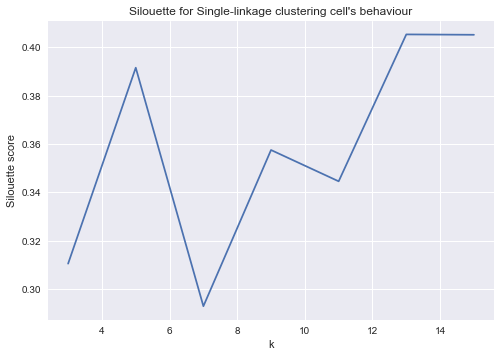

In [116]:

Nc = range(3, 17, 2)
s_linkage = []

for n_clusters in Nc:
        cuts = cut_tree(linkage_matrix['single'], n_clusters = n_clusters)
        labels = cuts.reshape((len(cuts),))
        score = silhouette_score(score_matrix, labels)
        print("For Single linkage Hierarchical Clustering, the Silhouette Coefficient with {} is {}".format(n_clusters, score))
        s_linkage.append(score)
    
plt.plot(Nc,s_linkage)
plt.grid(True)
plt.ylabel("Silouette score")
plt.xlabel("k")
plt.title("Silouette for Single-linkage clustering cell's behaviour")

Silhouette analysis on complete linkage clustering with different number of clusters

For Complete linkage Hierarchical Clustering, the Silhouette Coefficient with 3 is 0.2287593493450572
For Complete linkage Hierarchical Clustering, the Silhouette Coefficient with 5 is 0.3464403285447878
For Complete linkage Hierarchical Clustering, the Silhouette Coefficient with 7 is 0.41345886046628455
For Complete linkage Hierarchical Clustering, the Silhouette Coefficient with 9 is 0.42047369015612635
For Complete linkage Hierarchical Clustering, the Silhouette Coefficient with 11 is 0.40998990328296697
For Complete linkage Hierarchical Clustering, the Silhouette Coefficient with 13 is 0.4112681051869014
For Complete linkage Hierarchical Clustering, the Silhouette Coefficient with 15 is 0.3771077698985056


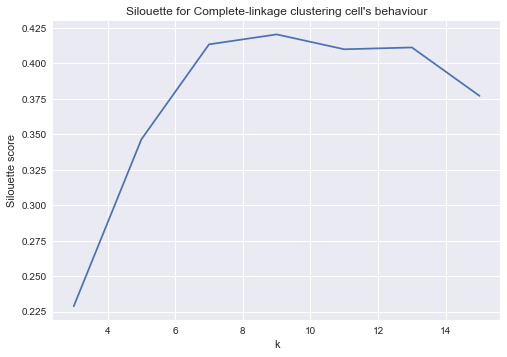

In [117]:
Nc = range(3, 17, 2)
c_linkage = []

for n_clusters in Nc:
        cuts = cut_tree(linkage_matrix['complete'], n_clusters = n_clusters)
        labels = cuts.reshape((len(cuts),))
        score = silhouette_score(score_matrix, labels)
        print("For Complete linkage Hierarchical Clustering, the Silhouette Coefficient with {} is {}".format(n_clusters, score))
        c_linkage.append(score)
    
plt.plot(Nc,c_linkage)
plt.grid(True)
plt.ylabel("Silouette score")
plt.xlabel("k")
plt.title("Silouette for Complete-linkage clustering cell's behaviour")